# Modeling dry reforming of methane using RMG-Cat
Based on the notebook to accompany the manuscript: <br/>
*"Automatic generation of microkinetic mechanisms for heterogeneous catalysis"* by<br/>
C. Franklin Goldsmith, School of Engineering, Brown University, franklin_goldsmith@brown.edu, and<br/>
Richard H. West, Department of Chemical Engineering, Northeastern University, r.west@northeastern.edu

To demonstrate the capabilities of automatic mechanism generation for heterogeneous catalysis we apply our mechanism generator software RMG-Cat to the problem of methane dry reforming on nickel. Comparison is made to the mechanism developed by Olaf Deutschmann and coworkers (Delgado, K.; Maier, L.; Tischer, S.; Zellner, A.; Stotz, H.; Deutschmann, O. Catalysts 2015, 5, 871–904.)

First, we print what git commit we were on when we ran this notebook, for both the source code (RMG-Py) and the database. 

In [1]:
%%bash
cd $RMGpy
pwd
git log -n1 --pretty=oneline
cd ../RMG-database
pwd
git log -n1 --pretty=oneline

/Users/emilymazeau/Code/RMG-Py
e6dec0fc8ca3dfbd35d1415b7d2c7896c7b13865 added try-except to where it was crashing issue #45
/Users/emilymazeau/Code/RMG-database
53563a9a0992aaab3baa66ed55c042451bcf4a62 Revert "Try removing the eley-rideeal reaction with StickingCoefficient kinetics."


## Model generation
We start with a base input file to generate a mechanism for CH4 plus CO2.
First we print the input file we'll use to generate the model.

In [2]:
%cat base/input.py

# Data sources
database(
    thermoLibraries=['surfaceThermoPt', 'primaryThermoLibrary', 'thermo_DFT_CCSDTF12_BAC','DFT_QCI_thermo'],
    reactionLibraries = [('CPOX_Pt/Deutschmann2006', False)],
    seedMechanisms = [],
    kineticsDepositories = ['training'],
    kineticsFamilies =['surface','default'],
    kineticsEstimator = 'rate rules',
    bindingEnergies = { # default values for Pt(111)
                       'C':(-6.750, 'eV/molecule'),
                       'H':(-0.240, 'eV/molecule'),
                       'O':(-1.030, 'eV/molecule'),
                       }
)

# List of species
species(
    label='X',
    reactive=True,
    structure=adjacencyList("1 X u0"),
)

species(
    label='He',
    reactive=True,
    structure=adjacencyList("1 He u0 p1 c0"),
)

species(
    label='CH4',
    reactive=True,
    structure=SMILES("[CH4]"),
)

species(
    label='H2',
    reactive=True,
    structure=SMILES("[H][H]"),
)

species(
    label='C2H6',

    structure=SMILES("CC"),
)

speci

Then we try running it. This will take a couple of minutes.

In [3]:
%%bash
python $RMGpy/rmg.py base/input.py > /dev/null
tail -n12 base/RMG.log

    Memory used: 560.41 MB

Making seed mechanism...
Performing final model checks...
No collision rate violators found.

MODEL GENERATION COMPLETED

The final model core has 16 species and 14 reactions
The final model edge has 62 species and 145 reactions

RMG execution terminated at Tue Jan  8 15:52:45 2019


/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first_order, \
/Users/emilymazeau

There are 16 species and 14 reactions.

## Data processing
Next we will import some libraries and set things up to start importing and analyzing the simulation results.

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

# The default output Type 3 (Type3) fonts can't be edited in Adobe Illustrator
# but Type 42 (TrueType) fonts can be, making it easier to move labels around
# slightly to improve layout before publication.
matplotlib.rcParams['pdf.fonttype'] = 42 

# Seaborn helps make matplotlib graphics nicer
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing

/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/Users/emilymazeau/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtyp

In [6]:
def get_last_csv_file(job_directory):
    """
    Find the CSV file from the largest model in the provided job directory.
    
    For CSV files named `simulation_1_13.csv` you want 13 to be the highest number.
    """
    solver_directory = os.path.join(job_directory,'solver')
    csv_files = sorted([f for f in os.listdir(solver_directory) if f.endswith('.csv') ],
                       key=lambda f: int(f[:-4].split('_')[2]))
    return os.path.join(solver_directory, csv_files[-1])
    
job_directory = 'base'
get_last_csv_file(job_directory)

'base/solver/simulation_1_16.csv'

We will use Pandas to import the csv file

In [7]:
last_csv_file = get_last_csv_file(job_directory)
data = pd.read_csv(last_csv_file)
data

,Time (s),Volume (m^3),Ar,Ne,N2,X(1),He(2),CH4(3),H2(4),C2H6(5),CH3(6),C3H8(7),H(8),C2H5(9),C4H8(10),C2H4(11),HeX(44),C2H4X(59)
0,0.000000e+00,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,0.000000e+00,0.000000e+00
1,1.095353e-24,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,1.870974e-18,7.067212e-19
2,3.066989e-24,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,5.238728e-18,1.978819e-18
3,7.010261e-24,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,1.197423e-17,4.523015e-18
4,1.489680e-23,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,2.544525e-17,9.611408e-18
5,3.066989e-23,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,5.238728e-17,1.978819e-17
6,6.221607e-23,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,1.062713e-16,4.014176e-17
7,1.253084e-22,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,2.140394e-16,8.084890e-17
8,2.514931e-22,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,4.295757e-16,1.622632e-16
9,5.038625e-22,0.000947,0.0,0.0,0.0,0.002746,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.5,8.606481e-16,3.250917e-16


In [8]:
def get_pandas_data(job_directory):
    """
    Get the last CSV file from the provided job directory,
    import it into a Pandas data frame, and tidy it up a bit.
    """
    last_csv_file = get_last_csv_file(job_directory)
    data = pd.read_csv(last_csv_file)
    
    # Make the Time into an index and remove it as a column
    data.index = data['Time (s)']
    del data['Time (s)']
    # Remove inerts that RMG added automatically but we're not using
    for i in 'Ar Ne'.split():
        del data[i]
    # Remove the Volume column
    del data['Volume (m^3)']
    # Set any amounts that are slightly negative (within the ODE solver's ATOL tolerance), equal to zero
    # to allow 'area' plots without warnings or errors.
    # Anything more negative than -1e-16 probably indicates a bug in RMG and should not be hidden here ;-)
    data[(data<0) & (data>-1e-16)] = 0
    return data

In [9]:
def rename_columns(data):
    """
    Removes the number (##) from the end of the column names, in place,
    unless doing so would make the names collide.
    Also renames a few species so the plot labels match the names in the manuscript.
    """
    import re
    old = data.columns
    new = [re.sub('\(\d+\)$','',n) for n in old]
    # don't translate names that would no longer be unique
    mapping = {k:v for k,v in zip(old,new) if new.count(v)==1}
    data.rename(columns=mapping, inplace=True)
    
    # Now change a few species that are named differently in the manuscript
    # than in the thermodynamics database used to build the model,
    # so that the plot labels match the manuscript.
    mapping = {'COX':'COvdwX', 'OCX': 'CO=X', 'C2H3X':'CH3CX', 'C2H3OX':'CH3CXO'}
    data.rename(columns=mapping, inplace=True)

In [10]:
data1 = get_pandas_data('base')
rename_columns(data1)
data1.columns

Index([u'N2', u'X', u'He', u'CH4', u'H2', u'C2H6', u'CH3', u'C3H8', u'H',
       u'C2H5', u'C4H8', u'C2H4', u'HeX', u'C2H4X'],
      dtype='object')

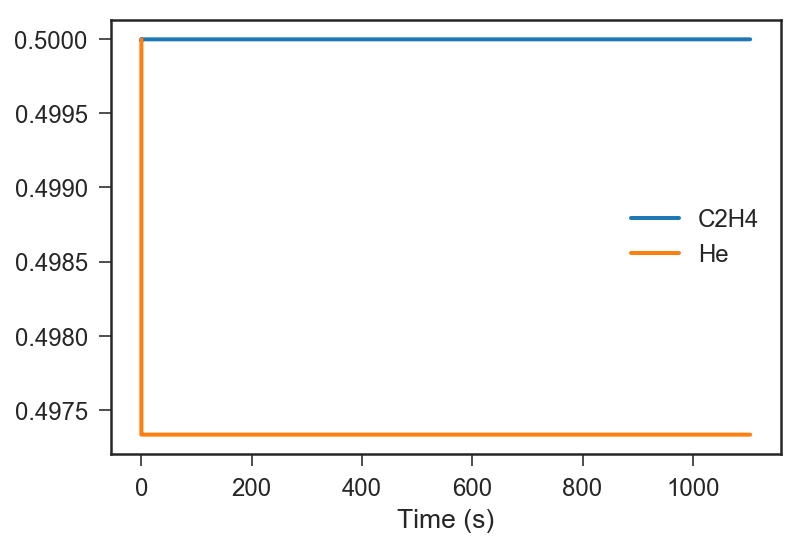

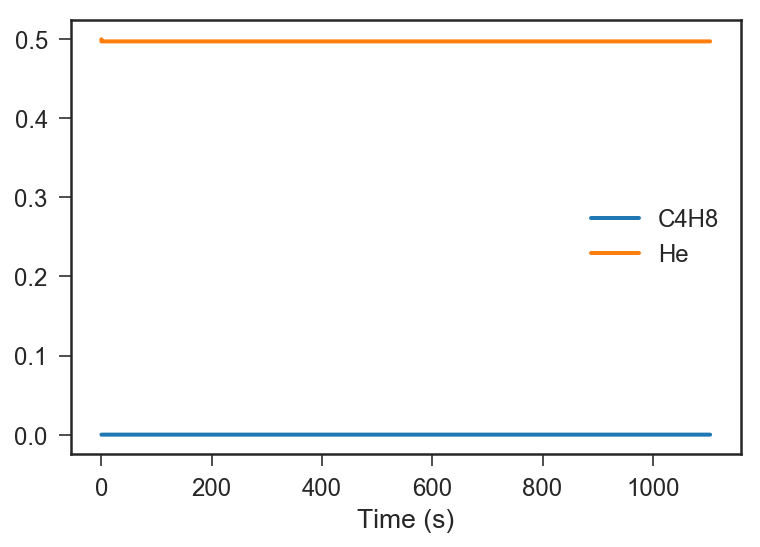

In [11]:
# Test it with some plots
data1[['C2H4', 'He']].plot.line()
data1[['C4H8', 'He']].plot.line()
#data1[['H2O']].plot.line()

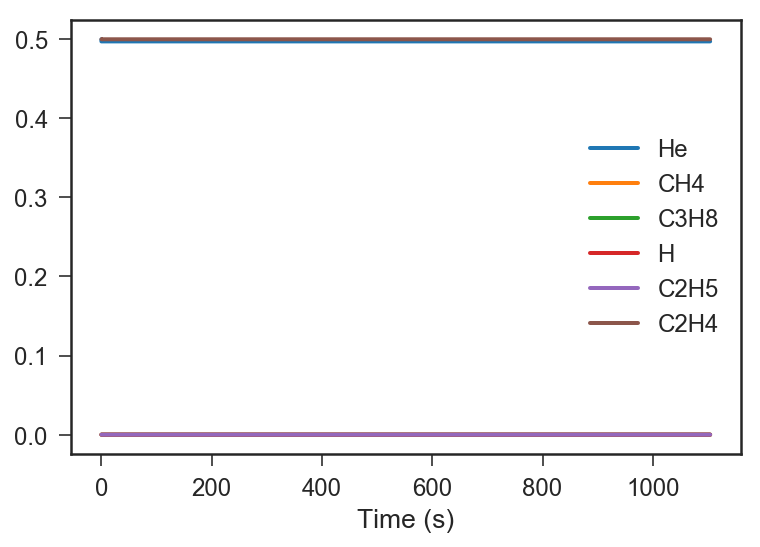

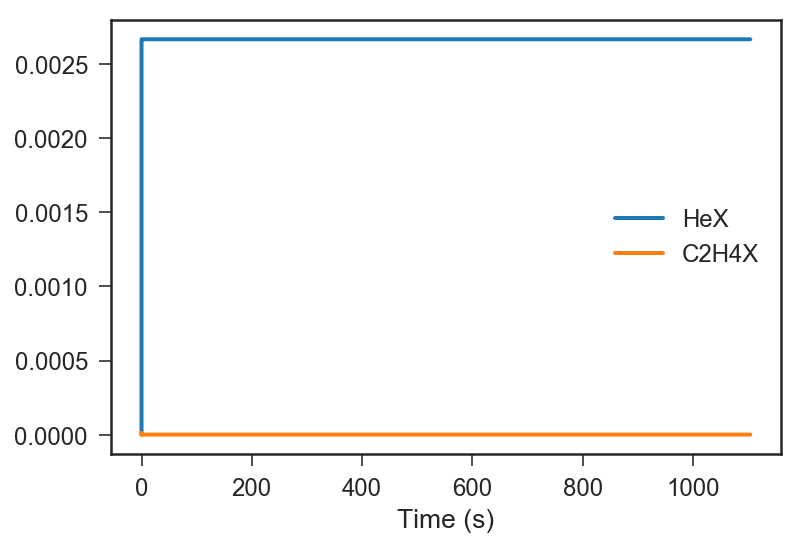

In [12]:
species_names = data1.columns
# just the gas phase species that aren't always zero:
gas_phase = [n for n in species_names if 'X' not in n and (data1[n]>0).any()]
# all the surface species
surface_phase = [n for n in species_names if 'X' in n]
surface_phase.remove('X')
data1[gas_phase].plot.line()
data1[surface_phase].plot.line()

Significant species (those that exceed 0.001 mol at some point)


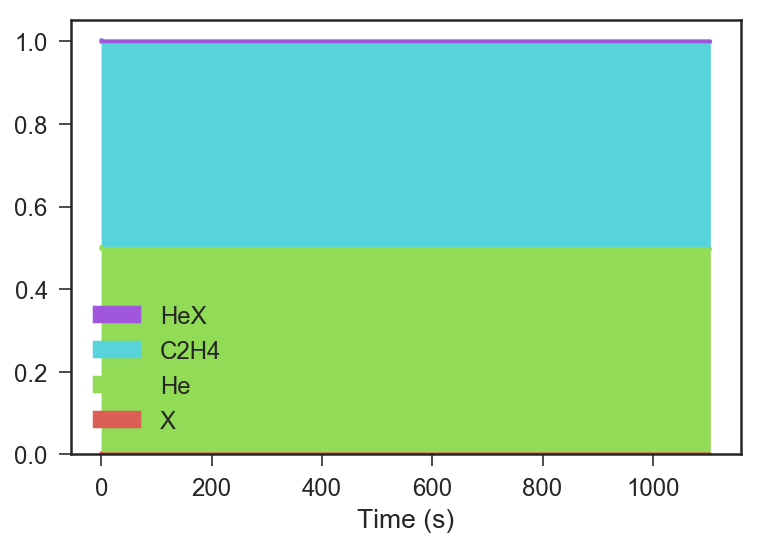

In [13]:
print "Significant species (those that exceed 0.001 mol at some point)"
significant = [n for n in data1.columns if(data1[n]>0.001).any()]
with sns.color_palette("hls", len(significant)):
    data1[significant].plot.area(legend='reverse')

The 2 surface species that exceed 1e-6 mol at some point


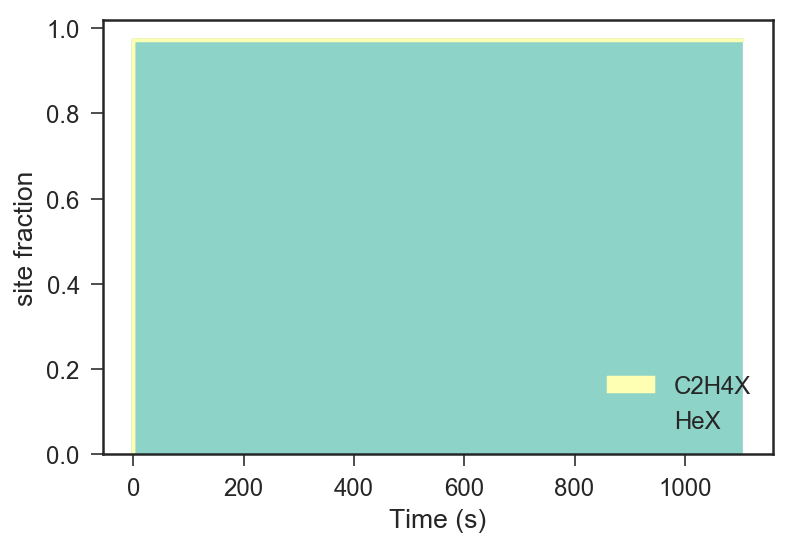

In [14]:
surface = [n for n in data1.columns if 'X' in n and n!='X' and (data1[n]>1e-6).any() ]
print "The {} surface species that exceed 1e-6 mol at some point".format(len(surface))
total_sites = max(data1['X'])
with sns.color_palette('Set3',len(surface)):
    (data1[surface]/total_sites).plot.area(legend='reverse')
    plt.ylabel('site fraction')

# Effect of binding energies

In [15]:
# First, make a series of input files in separate directories

with open(os.path.join('base', 'input.py')) as infile:
    input_file = infile.read()
    
base_directory = 'binding_energies'
def directory(carbon,oxygen):
    return os.path.join(base_directory, "c{:.3f}o{:.3f}".format(carbon,oxygen))

def make_input(binding_energies):
    """
    Make an input file for the given (carbon,oxygen) tuple (or iterable) of binding energies
    and return the name of the directory in which it is saved.
    """
    carbon, oxygen = binding_energies
    output = input_file
    out_dir = directory(carbon, oxygen)
    carbon_string = "'C':({:f}, 'eV/molecule')".format(carbon)
    output = re.sub("'C':\(.*?, 'eV/molecule'\)", carbon_string, output)
    oxygen_string = "'O':({:f}, 'eV/molecule')".format(oxygen)
    output = re.sub("'O':\(.*?, 'eV/molecule'\)", oxygen_string, output)
    os.path.exists(out_dir) or os.makedirs(out_dir)
    out_file = os.path.join(out_dir, 'input.py')
    with open(out_file,'w') as outfile:
        outfile.write(output)
    shutil.copy(os.path.join('base','run.sh'), out_dir)
    return out_dir

    
print make_input((-8,-3.5))
    

binding_energies/c-8.000o-3.500


In [16]:
def run_simulation(binding_energies):
    """
    Assuming a job file already exists, run it.  This one is local.
    Takes a tuple of binding energies, (carbon, oxygen)
    """
    carbon, oxygen = binding_energies
    job_directory = directory(carbon, oxygen)
    print job_directory
    assert os.path.exists(job_directory)
    return subprocess.check_call('./run.sh', cwd=job_directory)


(-6.5, -1.5)

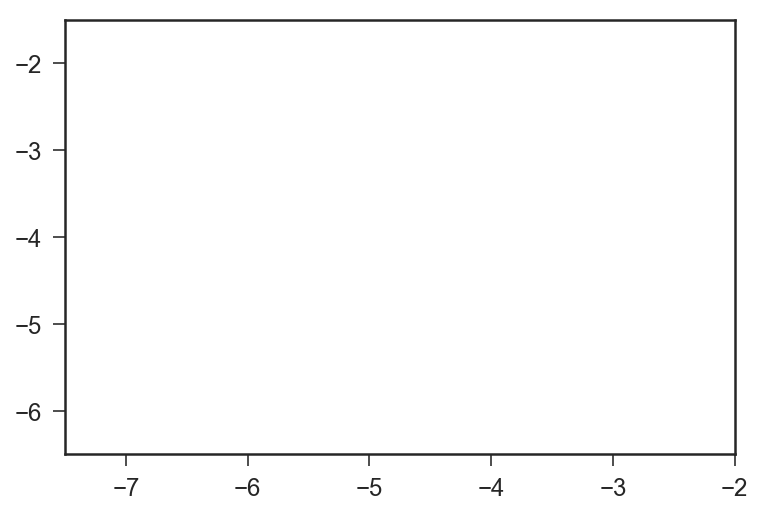

In [17]:
# Revised range
plt.xlim(-7.5,-2)
plt.ylim(-6.5,-1.5)

In [18]:
# Revised range
carbon_range = (-7.5, -2)
oxygen_range = (-6.5, -1.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, oxygen_range[0]:oxygen_range[1]:grid_size*1j]
mesh

array([[[-7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   ,
         -7.5   , -7.5   ],
        [-6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125,
         -6.8125, -6.8125],
        [-6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 ,
         -6.125 , -6.125 ],
        [-5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375,
         -5.4375, -5.4375],
        [-4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  ,
         -4.75  , -4.75  ],
        [-4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625,
         -4.0625, -4.0625],
        [-3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 ,
         -3.375 , -3.375 ],
        [-2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875,
         -2.6875, -2.6875],
        [-2.    , -2.    , -2.    , -2.    , -2.    , -2.    , -2.    ,
         -2.    , -2.    ]],

       [[-6.5   , -5.875 , -5.25  , -4.625 , -4.    , -3.375 , -2.75  ,
         -2.125 , -1.5   ]

In [19]:
experiments = mesh.reshape((2,-1)).T
experiments

array([[-7.5   , -6.5   ],
       [-7.5   , -5.875 ],
       [-7.5   , -5.25  ],
       [-7.5   , -4.625 ],
       [-7.5   , -4.    ],
       [-7.5   , -3.375 ],
       [-7.5   , -2.75  ],
       [-7.5   , -2.125 ],
       [-7.5   , -1.5   ],
       [-6.8125, -6.5   ],
       [-6.8125, -5.875 ],
       [-6.8125, -5.25  ],
       [-6.8125, -4.625 ],
       [-6.8125, -4.    ],
       [-6.8125, -3.375 ],
       [-6.8125, -2.75  ],
       [-6.8125, -2.125 ],
       [-6.8125, -1.5   ],
       [-6.125 , -6.5   ],
       [-6.125 , -5.875 ],
       [-6.125 , -5.25  ],
       [-6.125 , -4.625 ],
       [-6.125 , -4.    ],
       [-6.125 , -3.375 ],
       [-6.125 , -2.75  ],
       [-6.125 , -2.125 ],
       [-6.125 , -1.5   ],
       [-5.4375, -6.5   ],
       [-5.4375, -5.875 ],
       [-5.4375, -5.25  ],
       [-5.4375, -4.625 ],
       [-5.4375, -4.    ],
       [-5.4375, -3.375 ],
       [-5.4375, -2.75  ],
       [-5.4375, -2.125 ],
       [-5.4375, -1.5   ],
       [-4.75  , -6.5   ],
 

In [20]:
map(make_input, experiments)

['binding_energies/c-7.500o-6.500',
 'binding_energies/c-7.500o-5.875',
 'binding_energies/c-7.500o-5.250',
 'binding_energies/c-7.500o-4.625',
 'binding_energies/c-7.500o-4.000',
 'binding_energies/c-7.500o-3.375',
 'binding_energies/c-7.500o-2.750',
 'binding_energies/c-7.500o-2.125',
 'binding_energies/c-7.500o-1.500',
 'binding_energies/c-6.812o-6.500',
 'binding_energies/c-6.812o-5.875',
 'binding_energies/c-6.812o-5.250',
 'binding_energies/c-6.812o-4.625',
 'binding_energies/c-6.812o-4.000',
 'binding_energies/c-6.812o-3.375',
 'binding_energies/c-6.812o-2.750',
 'binding_energies/c-6.812o-2.125',
 'binding_energies/c-6.812o-1.500',
 'binding_energies/c-6.125o-6.500',
 'binding_energies/c-6.125o-5.875',
 'binding_energies/c-6.125o-5.250',
 'binding_energies/c-6.125o-4.625',
 'binding_energies/c-6.125o-4.000',
 'binding_energies/c-6.125o-3.375',
 'binding_energies/c-6.125o-2.750',
 'binding_energies/c-6.125o-2.125',
 'binding_energies/c-6.125o-1.500',
 'binding_energies/c-5.438o-

In [21]:
base_directory = 'binding_energies'
# base_directory = 'binding_energies_local'

In [22]:
def get_data(experiment):
    carbon, oxygen = experiment
    directory(carbon,oxygen)
    data = get_pandas_data(directory(carbon,oxygen))
    rename_columns(data)
    return data

In [23]:
datas = {tuple(e): get_data(e) for e in experiments}

In [24]:
datas.keys()

[(-2.0, -5.875),
 (-7.5, -3.375),
 (-6.8125, -5.875),
 (-2.0, -6.5),
 (-6.8125, -2.75),
 (-4.75, -5.875),
 (-6.125, -1.5),
 (-7.5, -6.5),
 (-2.6875, -5.875),
 (-4.75, -2.75),
 (-5.4375, -6.5),
 (-2.0, -1.5),
 (-4.75, -4.0),
 (-6.125, -4.625),
 (-4.0625, -4.625),
 (-6.125, -3.375),
 (-6.8125, -3.375),
 (-4.0625, -1.5),
 (-2.6875, -4.625),
 (-6.8125, -5.25),
 (-2.6875, -4.0),
 (-4.75, -1.5),
 (-3.375, -2.125),
 (-5.4375, -5.25),
 (-4.75, -4.625),
 (-5.4375, -2.75),
 (-2.0, -4.0),
 (-5.4375, -4.0),
 (-3.375, -2.75),
 (-6.125, -6.5),
 (-4.0625, -6.5),
 (-7.5, -5.25),
 (-2.0, -2.125),
 (-3.375, -5.875),
 (-4.75, -3.375),
 (-2.6875, -2.125),
 (-5.4375, -5.875),
 (-7.5, -5.875),
 (-3.375, -5.25),
 (-6.8125, -4.625),
 (-2.6875, -6.5),
 (-6.8125, -4.0),
 (-2.0, -4.625),
 (-6.8125, -1.5),
 (-4.0625, -2.125),
 (-3.375, -3.375),
 (-6.8125, -2.125),
 (-7.5, -2.75),
 (-2.6875, -1.5),
 (-4.0625, -5.875),
 (-4.0625, -4.0),
 (-4.0625, -5.25),
 (-4.75, -6.5),
 (-2.0, -2.75),
 (-5.4375, -1.5),
 (-3.375, 

In [25]:
def get_max_c4h8(experiment):
    data = datas[tuple(experiment)]
    return data[['C4H8']].max()
highest_c4h8 = max([float(get_max_c4h8(e)) for e in experiments])

[-7.5 -6.5]
[-7.5   -5.875]
[-7.5  -5.25]
[-7.5   -4.625]
[-7.5 -4. ]
[-7.5   -3.375]
[-7.5  -2.75]
[-7.5   -2.125]
[-7.5 -1.5]
[-6.8125 -6.5   ]
[-6.8125 -5.875 ]
[-6.8125 -5.25  ]
[-6.8125 -4.625 ]
[-6.8125 -4.    ]
[-6.8125 -3.375 ]
[-6.8125 -2.75  ]
[-6.8125 -2.125 ]
[-6.8125 -1.5   ]
[-6.125 -6.5  ]
[-6.125 -5.875]
[-6.125 -5.25 ]
[-6.125 -4.625]
[-6.125 -4.   ]
[-6.125 -3.375]
[-6.125 -2.75 ]
[-6.125 -2.125]
[-6.125 -1.5  ]
[-5.4375 -6.5   ]
[-5.4375 -5.875 ]
[-5.4375 -5.25  ]
[-5.4375 -4.625 ]
[-5.4375 -4.    ]
[-5.4375 -3.375 ]
[-5.4375 -2.75  ]
[-5.4375 -2.125 ]
[-5.4375 -1.5   ]
[-4.75 -6.5 ]
[-4.75  -5.875]
[-4.75 -5.25]
[-4.75  -4.625]
[-4.75 -4.  ]
[-4.75  -3.375]
[-4.75 -2.75]
[-4.75  -2.125]
[-4.75 -1.5 ]
[-4.0625 -6.5   ]
[-4.0625 -5.875 ]
[-4.0625 -5.25  ]
[-4.0625 -4.625 ]
[-4.0625 -4.    ]
[-4.0625 -3.375 ]
[-4.0625 -2.75  ]
[-4.0625 -2.125 ]
[-4.0625 -1.5   ]
[-3.375 -6.5  ]
[-3.375 -5.875]
[-3.375 -5.25 ]
[-3.375 -4.625]
[-3.375 -4.   ]
[-3.375 -3.375]
[-3.375 -2.7

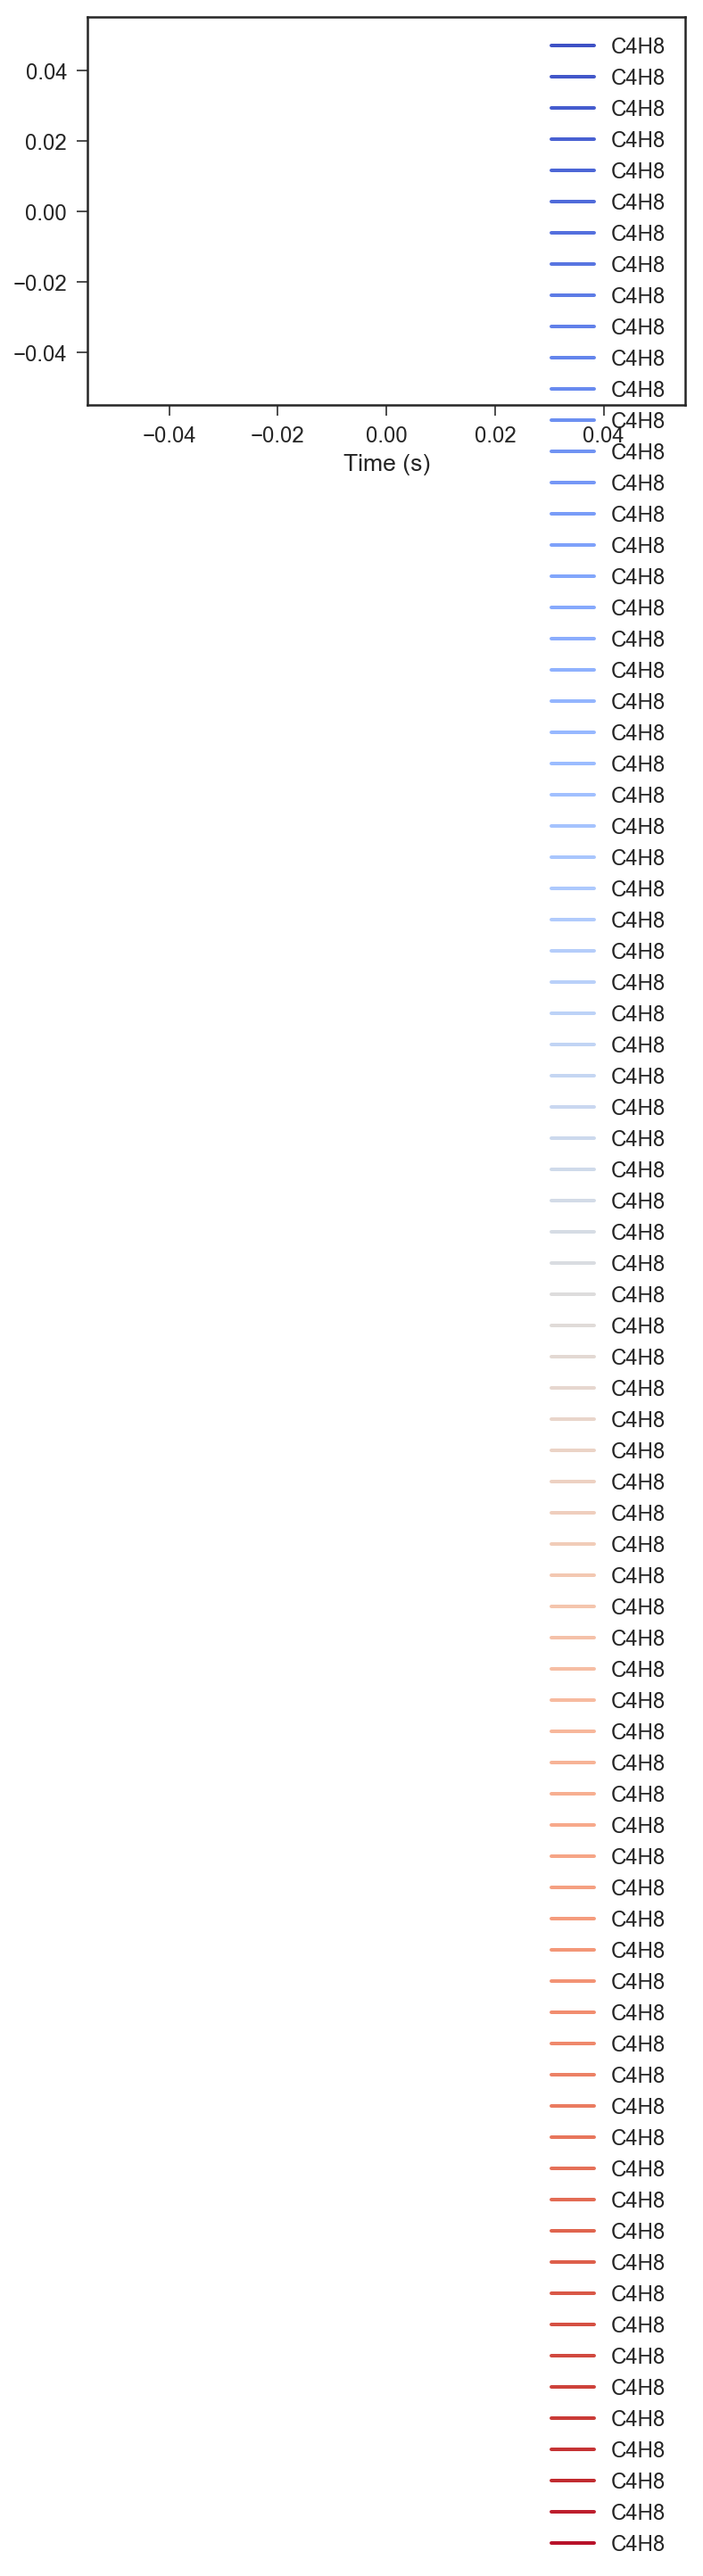

In [28]:
ax = plt.axes()
for experiment in experiments:
    print experiment
    data = get_data(experiment)
    (data[['C4H8']]/highest_c4h8).plot.line(ax=ax)

[-7.5 -6.5]
[-7.5   -5.875]
[-7.5  -5.25]
[-7.5   -4.625]
[-7.5 -4. ]
[-7.5   -3.375]
[-7.5  -2.75]
[-7.5   -2.125]
[-7.5 -1.5]
[-6.8125 -6.5   ]


/Users/emilymazeau/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


[-6.8125 -5.875 ]
[-6.8125 -5.25  ]
[-6.8125 -4.625 ]
[-6.8125 -4.    ]
[-6.8125 -3.375 ]
[-6.8125 -2.75  ]
[-6.8125 -2.125 ]
[-6.8125 -1.5   ]
[-6.125 -6.5  ]
[-6.125 -5.875]
[-6.125 -5.25 ]
[-6.125 -4.625]
[-6.125 -4.   ]
[-6.125 -3.375]
[-6.125 -2.75 ]
[-6.125 -2.125]
[-6.125 -1.5  ]
[-5.4375 -6.5   ]
[-5.4375 -5.875 ]
[-5.4375 -5.25  ]
[-5.4375 -4.625 ]
[-5.4375 -4.    ]
[-5.4375 -3.375 ]
[-5.4375 -2.75  ]
[-5.4375 -2.125 ]
[-5.4375 -1.5   ]
[-4.75 -6.5 ]
[-4.75  -5.875]
[-4.75 -5.25]
[-4.75  -4.625]
[-4.75 -4.  ]
[-4.75  -3.375]
[-4.75 -2.75]
[-4.75  -2.125]
[-4.75 -1.5 ]
[-4.0625 -6.5   ]
[-4.0625 -5.875 ]
[-4.0625 -5.25  ]
[-4.0625 -4.625 ]
[-4.0625 -4.    ]
[-4.0625 -3.375 ]
[-4.0625 -2.75  ]
[-4.0625 -2.125 ]
[-4.0625 -1.5   ]
[-3.375 -6.5  ]
[-3.375 -5.875]
[-3.375 -5.25 ]
[-3.375 -4.625]
[-3.375 -4.   ]
[-3.375 -3.375]
[-3.375 -2.75 ]
[-3.375 -2.125]
[-3.375 -1.5  ]
[-2.6875 -6.5   ]
[-2.6875 -5.875 ]
[-2.6875 -5.25  ]
[-2.6875 -4.625 ]
[-2.6875 -4.    ]
[-2.6875 -3.375 ]
[-

Text(0,0.5,'Normalized CO concentration')

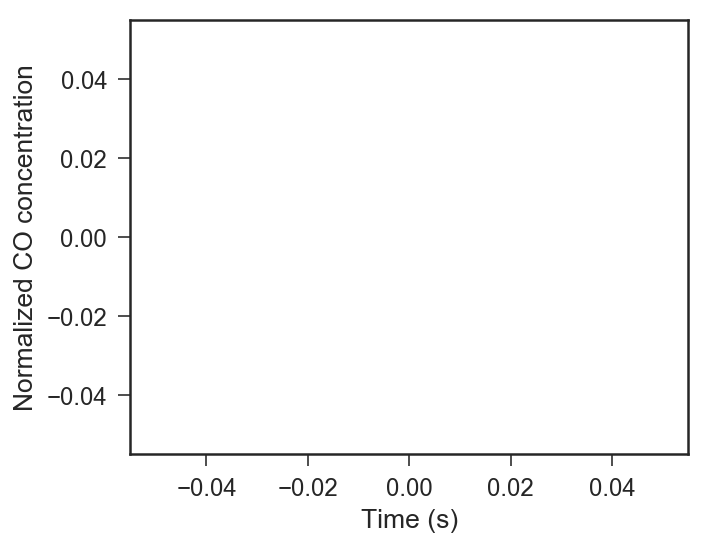

In [29]:
import seaborn as sns
plt.figure(figsize=(5, 4))
num_lines = len(experiments)
sns.set_palette(sns.color_palette("coolwarm",num_lines))

ax = plt.axes()
def make_label(experiment):
    return "{:+.1f}, {:+.1f}".format(*experiment)

for experiment in experiments:
    print experiment
    data = get_data(experiment)
    times = np.array(data.index)
    normalized = data[['C4H8']].values / highest_c4h8
    ax.plot(times, normalized, label=make_label(experiment))
    #normalized.plot.line(ax=ax, label=make_label(experiment))
    #ax.text(times[-10], normalized[-10], make_label(experiment))

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Normalized CO concentration')

In [31]:
import seaborn as sns
plt.figure(figsize=(5, 4))
num_lines = len(experiments)
sns.set_palette(sns.color_palette("coolwarm",num_lines))
ax = plt.axes()

def make_label(experiment):
    return "{:+.1f}, {:+.1f}".format(*experiment)

for experiment in experiments:
    print experiment
    data = get_data(experiment)
    times = np.array(data.index)
    normalized = data[['C4H8']].values[:,0] / highest_c4h8
    ax.loglog(times, normalized, label=make_label(experiment))
    try:
        i = (np.nonzero((np.log10(times)+np.log10(normalized)) > -10))[0][0]
    except IndexError:
        i = -1
    print i, times[i], normalized[i]
    ax.text(times[i], normalized[i], make_label(experiment), rotation=45, ha='center', va='center', fontsize=12)
    
    # plt.ylim(1e-10, 1)
    # plt.xlim(1e-10, 1)
    # plt.show()
    # ax = plt.axes()

plt.ylim(1e-10, 1)
plt.xlim(1e-10, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Normalized CO concentration')


[-7.5 -6.5]
-1 6.305162802493977e-08 nan
[-7.5   -5.875]
-1 6.305162802493977e-08 nan
[-7.5  -5.25]
-1 6.305162802493977e-08 nan
[-7.5   -4.625]
-1 6.305162802493977e-08 nan
[-7.5 -4. ]
-1 6.305162802493977e-08 nan
[-7.5   -3.375]
-1 6.305162802493977e-08 nan
[-7.5  -2.75]
-1 

/Users/emilymazeau/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  
/Users/emilymazeau/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/emilymazeau/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


6.305162802493977e-08 nan
[-7.5   -2.125]
-1 6.305162802493977e-08 nan
[-7.5 -1.5]
-1 6.305162802493977e-08 nan
[-6.8125 -6.5   ]
-1 1104.0309041321834 nan
[-6.8125 -5.875 ]
-1 1104.0309041321834 nan
[-6.8125 -5.25  ]
-1 1104.0309041321834 nan
[-6.8125 -4.625 ]
-1 1104.0309041321834 nan
[-6.8125 -4.    ]
-1 1104.0315912752837 nan
[-6.8125 -3.375 ]
-1 1104.0309041321834 nan
[-6.8125 -2.75  ]
-1 1104.0309041321834 nan
[-6.8125 -2.125 ]
-1 1104.0309041321834 nan
[-6.8125 -1.5   ]
-1 1104.0309041321834 nan
[-6.125 -6.5  ]
-1 1104.0309041321834 nan
[-6.125 -5.875]
-1 1104.0309041321834 nan
[-6.125 -5.25 ]
-1 1104.0309041321834 nan
[-6.125 -4.625]
-1 1104.0309041321834 nan
[-6.125 -4.   ]
-1 1104.0309041321834 nan
[-6.125 -3.375]
-1 1104.0309041321834 nan
[-6.125 -2.75 ]
-1 1104.0309041321834 nan
[-6.125 -2.125]
-1 1104.0309041321834 nan
[-6.125 -1.5  ]
-1 1104.0315912752837 nan
[-5.4375 -6.5   ]
-1 1104.0309041321834 nan
[-5.4375 -5.875 ]
-1 1104.0309041321834 nan
[-5.4375 -5.25  ]
-1 1104.

Text(0,0.5,'Normalized CO concentration')

/Users/emilymazeau/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: cannot convert float NaN to integer

<Figure size 360x288 with 1 Axes>

In [ ]:
ax = plt.axes()
for experiment in experiments:
    print experiment
    data = get_data(experiment)
    normalized = data[['CO']] / highest_co
    linearized = -np.log( 1 - normalized)
    linearized.plot.line(ax=ax)
    

In [ ]:
sns.set_palette('Set1')
x_data = np.array(linearized.index)
y_data = linearized.values[:,0] 
plt.plot(x_data, y_data)
plt.show()

import scipy.stats
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x_data, y_data)
print(slope, intercept, rvalue, pvalue, stderr)

print("Slope: {}".format(slope))
print("Intercept: {}".format(intercept))
print("Coefficient of determination (r squared): {}".format(rvalue*rvalue))
print("p-value (probability that the slope is zero): {}".format(pvalue))
print("Standard error in slope: {}".format(stderr))
plt.plot(x_data, y_data, '.')
plt.plot(x_data, x_data*slope+intercept)
plt.show()

In [ ]:
sns.set_palette('Set1')

def my_function(time, rate):
    "Thing we want to fit."
    return 1. - np.exp(-1*time*rate)
import scipy.optimize


def fit_rate(data):
    normalized = data[['CO']] / highest_co
    x_data = np.array(normalized.index)
    y_data = normalized.values[:,0] 

    popt, pcov = scipy.optimize.curve_fit(my_function, x_data, y_data)
    optimal_parameters = popt
    parameter_errors = np.sqrt(np.diag(pcov))
    print("Rate: {} +/- {} (1 st. dev.)".format(optimal_parameters[0],parameter_errors[0]))

    plt.plot(x_data, y_data, 'o')
    plt.plot(x_data, my_function(x_data, *optimal_parameters))
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized CO concentration')
    
    plt.show()
    fitted_rate = optimal_parameters[0]
    return fitted_rate

rates = []
for experiment in experiments:
    print experiment
    data = get_data(experiment)
    rate = fit_rate(data)
    print rate
    rates.append(rate)

rates
    

In [ ]:
rates = np.array(rates)
fixed_rates = rates * (rates>0) + (1e-9 * (rates<0))
log_rates = np.log(fixed_rates)
log_rates

In [ ]:
experiments

In [ ]:
rate_grid = np.reshape(log_rates, (grid_size,grid_size))

In [ ]:
ax = sns.heatmap(rate_grid)

In [ ]:
extent = carbon_range + oxygen_range
extent

In [ ]:
plt.imshow(rate_grid, interpolation='spline16', origin='lower', extent=extent, aspect='equal')
plt.plot(-5.997, -4.485, 'ok')
plt.text(-5.997, -4.485, 'Ni(111)')

In [ ]:
# (1)	Medford, A. J.; Lausche, A. C.; Abild-Pedersen, F.; Temel, B.; Schjødt, N. C.; Nørskov, J. K.; Studt, F. Activity and Selectivity Trends in Synthesis Gas Conversion to Higher Alcohols. Topics in Catalysis 2014, 57 (1-4), 135–142 DOI: 10.1007/s11244-013-0169-0.

medford_energies = { # Carbon, then Oxygen
'Ru': ( 0.010349288486416697, -2.8153856448231256),
'Rh': ( 0.16558861578266493, -2.546620868091181),
'Ni': ( 0.3001293661060802, -2.5881741535441853),
'Ir': ( 0.36222509702457995, -2.826185484230718),
'Pd': ( 0.28460543337645516, -1.207119596734621),
'Pt': ( 0.8796895213454077, -1.445820136503547),
'Cu': ( 2.323415265200518, -1.7218249542757729),
'Ag': ( 3.855109961190168, -0.8341504215550701),
'Au': ( 3.5601552393272975, -0.10963108355266138),
}

In [ ]:
# Shift medford's energies so that Ni matches Wayne Blaylock's Ni
blaylock_ni = np.array([-5.997, -4.485])
old_ni = np.array(medford_energies['Ni'])
shifted_energies = {metal: tuple(blaylock_ni + np.array(E)-old_ni) for metal,E in medford_energies.items()}
shifted_energies


In [ ]:
plt.imshow(rate_grid, interpolation='spline16', origin='lower', extent=extent, aspect='equal')
for metal, coords in shifted_energies.iteritems():
    plt.plot(coords[0], coords[1], 'ok')
    plt.text(coords[0], coords[1], metal)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)


In [ ]:
# For close packed surfaces from
# Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.; Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. Scaling Properties of Adsorption Energies for Hydrogen-Containing Molecules on Transition-Metal Surfaces. Phys. Rev. Lett. 2007, 99 (1), 016105 DOI: 10.1103/PhysRevLett.99.016105.
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
'Ag': ( -2.9545454545454533, -2.9282552993244817),
'Au': ( -3.7499999999999973, -2.302236198462614),
}

In [ ]:
abildpedersen_energies['Pt'][0] - abildpedersen_energies['Ni'][0]

In [ ]:
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2

In [ ]:
plt.imshow(rate_grid.T, interpolation='spline16', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w','Cu':'w'}.get(metal,'k')
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

In [ ]:
new_rates = []
for experiment in experiments:
    print experiment
    data = get_data(experiment)
    times = np.array(data.index)
    normalized = data[['CO']].values[:,0] / highest_co
    try:
        i = (np.nonzero((np.log10(times)+np.log10(normalized)) > -10))[0][0]
        time = times[i]
    except IndexError:
        time = 1.0
    new_rates.append(1./time)
new_log_rates = np.log(np.array(new_rates))
print new_log_rates


In [ ]:
new_rate_grid = np.reshape(new_log_rates, (grid_size,grid_size))
plt.imshow(new_rate_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w','Cu':'w'}.get(metal,'k')
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

In [ ]:
def get_reaction_count(experiment):
    d = directory(*experiment)
    f = os.path.join(d,'chemkin','chem_annotated.inp')
    with open(f) as chemkin:
        r = re.compile('\! Reaction index: Chemkin \#(\d+)')
        for line in chemkin:
            m = r.match(line)
            if m:
                count = int(m.group(1))
    return count
    
get_reaction_count(experiment)

In [ ]:
i=35
print experiments[i]
print get_reaction_count(experiments[i])

In [ ]:
reaction_counts = map(get_reaction_count, experiments)
reaction_counts_grid = np.log10(np.reshape(reaction_counts, (grid_size,grid_size)))
plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w','Cu':'w'}.get(metal,'k')
    color='k'
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range2)
plt.ylim(oxygen_range2)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

for e,n in zip(experiments,reaction_counts):
    plt.text(e[0],e[1],n,color='w',ha='center', va='center')
#plt.colorbar()

In [ ]:
reaction_counts_grid = np.reshape(reaction_counts, (grid_size,grid_size))
ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)

# STOP HERE.
stuff below is left over from old notebook

In [ ]:
raise NotImplementedError("Stop here.")


## Model generation: with RMG-Cat reaction families
Now lets look at the version that generates a mechanism by applying reaction families.
First, inspect how the input file differs from the one above. 

In [ ]:
%%bash
python $RMGpy/rmg.py ch4_co2_families/input.py > /dev/null
tail -n12 ch4_co2_families/RMG.log

## Data processing
First, we make a few plots of the new model.
Mostly just to show how it can be done, and to see what the results look like. These aren't very pretty as they're not going in the manuscript.

In [ ]:
data2 = get_pandas_data('ch4_co2_families')
rename_columns(data2)
data2.columns

In [ ]:
get_last_csv_file('ch4_co2_families')

In [ ]:
data2[['CH4', 'CO2']].plot.line()
data2[['CO', 'H2']].plot.line()
data2[['H2O']].plot.line()

In [ ]:
print "All species"
data2.plot.area()
plt.show()

In [ ]:
print "Significant species (those that exceed 0.001 mol at some point)"
significant = [n for n in data2.columns if(data2[n]>0.001).any()]
with sns.color_palette("hls", len(significant)):
    data2[significant].plot.area(legend='reverse')

In [ ]:
surface = [n for n in data2.columns if 'X' in n and n!='X' and (data2[n]>1e-6).any()]
print "The {} surface species that exceed 1e-6 mol at some point".format(len(surface))
with sns.color_palette('Set3',len(surface)):
    data2[surface].plot.area(legend='reverse')

In [ ]:
species_names = data2.columns
gas_phase = [n for n in species_names if 'X' not in n and (data2[n]>0).any()]
surface_phase = [n for n in species_names if 'X' in n]
surface_phase.remove('X')
print "Total moles of gas"
data2[gas_phase].sum(axis=1).plot()
plt.show()
print "All gas phase species"
data2[gas_phase].plot.line()
plt.show()
print "All surface species"
data2[surface_phase].plot.line()
plt.show()

In [ ]:
print "A comparison of the two reactants across the two models"
ax = plt.subplot()
data1[['CH4', 'CO2']].plot.line(ax=ax) # seed
data2[['CH4', 'CO2']].plot.line(ax=ax, style=':') # families
plt.show()

## Model comparison
Now we will start making some prettier plots for the manuscript, comparing the two models

In [ ]:
plt.rcParams.update({'mathtext.default':  'regular' }) # make the LaTeX subscripts (eg. CH4) use regular font
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 1.5}) # Tweak the font size and default line widths

def comparison_plot(subplot_axis=None, species='CH4'):
    label = re.sub('(\d)',r'$_\1$',species)
    ax1 = subplot_axis or plt.subplot()
    
    plt.locator_params(nbins=4) # fewer tick marks
    
    ax1.plot(0, data1[species].iloc[0], 'ko')
    ax1.plot(data1.index, data1[species],'k--', linewidth=2.5)
    ax1.plot(data2.index, data2[species],'r-')
    plt.xlim(0,1)
    ax1.set_ylabel('moles')
    ax1.set_xlabel('time (s)')
    
    # Legend
    dummy = matplotlib.patches.Patch(alpha=0)
    plt.legend([dummy],[label], loc='best', fontsize=12)
    
    plt.tight_layout()

fig = plt.figure(figsize=(2.5,2.5))
ax1 = comparison_plot()

In [ ]:
fig = plt.figure(figsize=(7,4))
for n, species in enumerate('CH4 CO H2O CO2 H2'.split()):
    ax = plt.subplot(2,3,n+1)
    comparison_plot(ax, species)

ax = plt.subplot(2,3,6)
ax.axis('off')
red = matplotlib.lines.Line2D([], [], color='r', label='RMG-Cat')
dash = matplotlib.lines.Line2D([], [], color='k', linestyle='--', linewidth=2.5, label='Delgado et al.')

plt.legend(handles=[red, dash], loc='best',fontsize=12)
plt.tight_layout()
plt.savefig('Multi-panel gas comparison.pdf', bbox_inches='tight')

In [ ]:
def extras_plot(subplot_axis=None, species_list=['C2H6','CH2O'], label_positions=None):
    """
    Plot the requested species on one plot,
    with just the 'data2' (RMG-Cat) values.
    Useful for species not in the Delgado model.
    """
    ax1 = subplot_axis or plt.subplot()
    plt.locator_params(nbins=4) # fewer tick marks
    plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
    
    for i,species in enumerate(species_list):
        label = re.sub('(\d)',r'$_\1$',species)
        ax1.semilogy(data2.index, data2[species],'-', label=label)
        plt.ylim(ymin=1e-9)
        plt.xlim(0,1)
        ax1.set_ylabel('moles')
        ax1.set_xlabel('time (s)')
        # Manually constructed label
        x = label_positions[species] if label_positions and species in label_positions else 0.5
        y = data2[x:][species].iloc[0]
        ax1.text(x,y,label,
                 verticalalignment='bottom',
                 color=sns.color_palette()[i],
                 fontsize=10)
        plt.tight_layout()

# test it
fig = plt.figure(figsize=(4,4))
with sns.color_palette("Dark2", 3):
    extras_plot(species_list='C2H6 CH2O C3H8'.split())


In [ ]:
# Everything that exceeds some lower threshold
gas_phase = [n for n in species_names if 'X' not in n and (data2[n]>1.1e-9).any()]
# Remove things already in the comparison plots
gas_phase = [n for n in gas_phase if n not in 'CH4 CO H2O CO2 H2 N2'.split()]
print "Extra gas phase species of note are {}.".format(", ".join(gas_phase))
fig = plt.figure(figsize=(3.25,3.25))
with sns.color_palette("Dark2", len(gas_phase)):
    extras_plot(species_list=gas_phase, 
               label_positions={'C2H5':0.15, 'C3H8':0.1, 'CH3OH':0.7, 'H':0.3})
plt.savefig('Gas extra species (many).pdf',bbox_inches='tight')

In [ ]:
def multi_comparison_plot(subplot_axis=None, species_list=['X', 'HX'], label_positions=None):
    """
    Plot many surface species AND their comparison (if there is one) from the Delgado model
    on a semilog plot. 
    """
    ax1 = subplot_axis or plt.subplot()
    plt.locator_params(nbins=4) # fewer tick marks
    for i,species in enumerate(species_list):
        assert 'X' in species, "For surface species only (y axis is normalized for fractional coverage)."
        label = re.sub('(\d)',r'$_\1$',species)
        label = label.replace('X','*')
        if label=='*': label = 'vacant'
        if species in data1.columns:
            sites = data1['X'].iloc[0]
            ax1.semilogy(data1.index, data1[species]/sites,'k--', linewidth=2.5)
        sites = data2['X'].iloc[0]
        ax1.semilogy(data2.index, data2[species]/sites,'-')
        plt.xlim(0,1)
        plt.ylim(ymin=1e-6)
        ax1.set_ylabel('site fraction')
        ax1.set_xlabel('time (s)')
        ## Manually constructed label
        x = label_positions[species] if label_positions and species in label_positions else 0.5
        y = data2[x:][species].iloc[0] / sites
        ax1.text(x,y,label, 
                 fontsize=10,
                 verticalalignment='bottom',
                 color=sns.color_palette()[i])

# test it
multi_comparison_plot()

In [ ]:
species_names = data2.columns
gas_phase = [n for n in species_names if 'X' not in n and (data2[n]>0).any()]

sites = data2['X'].iloc[0] # initial number of suface sites
# get only adsorbates that exceed a site fraction of 1e-6
surface_phase = [n for n in species_names if 'X' in n and (data2[n]>sites*1e-6).any()]
surface_phase

In [ ]:
label_positions = {'HX':0.4, 'COX':0.6, 'CHX':0.7, 'OX':0.4, 
                   'CHOX':0.6, 'CX':0.3, 'CH2X':0.05,
                   'C2HOX':0.8, 'CHO2X':0.7}
fig = plt.figure(figsize=(5,5))
with sns.color_palette("Dark2", len(surface_phase)):
    ax1 = multi_comparison_plot(species_list=surface_phase, label_positions=label_positions)
plt.tight_layout()
plt.savefig('Surface comparison semilog.pdf', bbox_inches='tight')

In [ ]:
def multi_comparison_loglogplot(subplot_axis=None, species_list=['X', 'HX'], label_positions=None):
    """
    Plot many things AND their comparison (if there is one) from the Delgado model
    on a log-log plot
    """
    ax1 = subplot_axis or plt.subplot()
    for i,species in enumerate(species_list):
        label = re.sub('(\d)',r'$_\1$',species)
        label = label.replace('X','*')
        if label=='*': label='vacant'
        if species in data1.columns:
            sites = data1['X'].iloc[0]
            ax1.loglog(data1.index, data1[species]/sites,'k--', linewidth=2.5)
        sites = data2['X'].iloc[0]
        ax1.loglog(data2.index, data2[species]/sites,'-')
        plt.xlim(1e-6,1)
        plt.ylim(ymin=1e-6)
        ax1.set_ylabel('site fraction')
        ax1.set_xlabel('time (s)')
        ## Manually constructed label
        x = label_positions[species] if label_positions and species in label_positions else 3.0
        x = 10**(-1*x)
        y = data2[x:][species].iloc[0] / sites
        if x==1: x=1.3 # move them right just a little
        ax1.text(x,y,label, fontsize=10,
                 verticalalignment='center' if x==1.3 else 'bottom',
                 color=sns.color_palette()[i])  

label_positions = {'HX':0.5, 'COX':0, 'CX':2, 'C2HOX':0,
                  'CH3CXO':0, 'CH3CX':0, 'OX':5, 'CHO2X':0,
                  'CH2X':2.5}
fig = plt.figure(figsize=(5,4))
with sns.color_palette("Dark2", len(surface_phase)):
    ax1 = multi_comparison_loglogplot(species_list=surface_phase, label_positions=label_positions)
plt.tight_layout()
plt.savefig('Surface comparison loglog.pdf',bbox_inches='tight')

# Effect of tolerance
Now we investigate the effect of gradually decreasing (tightening) the tolerance

In [ ]:
# First, make a series of input files in separate directories

base_directory = 'ch4_co2_tolerances'

with open(os.path.join(base_directory, 'input.template.py')) as infile:
    input_file = infile.read()

def directory(i):
    return os.path.join(base_directory, "ch4_co2_tolerance_m{}".format(i))

for i in range(9):
    tolerance = 0.1**i
    tolerance_string = 'toleranceMoveToCore={:.1e},'.format(tolerance)
    print tolerance_string
    input_file = re.sub('toleranceMoveToCore\s*=\s*(.*?),', tolerance_string, input_file)
    os.path.exists(directory(i)) or  os.makedirs(directory(i))
    with open(os.path.join(directory(i), 'input.py'), 'w') as outfile:
        outfile.write(input_file)
    print "Saved to {}/input.py".format(directory(i))


In [ ]:
# Now run all the jobs
# Don't execute this cell unless you have a while to wait.
import subprocess
import sys
for i in range(9):
    print "Attempting to run job {} in directory {}".format(i, directory(i))
    try:
        retcode = subprocess.call("python $RMGpy/rmg.py {}/input.py".format(directory(i)), shell=True)
        if retcode < 0:
            print >>sys.stderr, "Process was terminated by signal", -retcode
        elif retcode > 0:
            print >>sys.stderr, "Process returned", retcode
        else:
            print "Success"
    except OSError as e:
        print >>sys.stderr, "Execution failed:", e

In [ ]:
# Now read the ends of the log files and extract the mechanism sizes.
epsilon = []
core_species = []
core_rxns = []
edge_species = []
edge_rxns = []

for i in range(9):
    dirname = directory(i)
    print "reading from ", directory(i)
    last_lines = subprocess.check_output(['tail', '-n','6', os.path.join(directory(i),'RMG.log')])

    match = re.search('The final model core has (\d+) species and (\d+) reactions', last_lines)
    if match is None: 
        print "Trouble with {}/RMG.log:\n{}".format(directory(i),last_lines)
    core_species.append(int(match.group(1)))
    core_rxns.append(int(match.group(2)))
    match = re.search('The final model edge has (\d+) species and (\d+) reactions', last_lines)
    if match is None: 
        print "Trouble with {}/RMG.log:\n{}".format(directory(i),last_lines)
    edge_species.append(int(match.group(1)))
    edge_rxns.append(int(match.group(2)))
    epsilon.append( 0.1**i )

#remove the four inerts, N2, Ar, Ne, and He that RMG automatically adds
core_species = np.array(core_species) - 4
edge_species = np.array(edge_species) - 4


In [ ]:
# Now count the reactions by type
Deutschmann = []
abstraction = []
adsorption = []
dissociation = []
for i in range(9):
    ckfilepath = os.path.join(directory(i), 'chemkin', 'chem_annotated.inp')
    re_library = re.compile('! Library reaction: (.*)')
    re_family = re.compile('! Template reaction: (.*)')
    from collections import Counter
    counts = Counter()
    with open(ckfilepath) as ckfile:
        for line in ckfile:
            match = re_family.match(line) or re_library.match(line)
            if match is None:
                continue
            source = match.group(1)
            counts[source] += 1
    counts

    Deutschmann.append(counts['Deutschmann_Ni'])
    abstraction.append(counts['Surface_Abstraction'])
    adsorption.append(counts['Surface_Adsorption_Dissociative'] + counts['Surface_Adsorption_Single'])
    dissociation.append(counts['Surface_Dissociation'])
print 'Deutschmann',Deutschmann
print 'abstraction',abstraction
print 'adsorption',adsorption
print 'dissociation',dissociation

Deutschmann = np.array(Deutschmann)
abstraction = np.array(abstraction)
adsorption = np.array(adsorption)
dissociation = np.array(dissociation)
total = Deutschmann + abstraction + adsorption + dissociation
assert (total == np.array(core_rxns)).all(), "Sum of counters doesn't equal core_rxns from above"

In [ ]:
# Now plot the figure
fig = plt.figure()
fig.set_size_inches(7,3.5) #set size, in inches
gs = matplotlib.gridspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

ax0.loglog(epsilon, edge_species, 'r^-', label='edge')
ax0.loglog(epsilon, core_species, 'bo-', label='core')

ax1.loglog(epsilon, edge_rxns, 'r^-', label='edge')
ax1.loglog(epsilon, core_rxns, 'bo-', label='core')

#ax2.semilogx(epsilon, Deutschmann, 'k:', label='Deutschmann')
#ax2.semilogx(epsilon, abstraction, 'b-', label='abstraction')
#ax2.semilogx(epsilon, dissociation, 'g--', label='dissociation')
#ax2.semilogx(epsilon, adsorption, 'r-.', label='adsorption')

stacks = ax2.stackplot(epsilon, Deutschmann, adsorption, dissociation, abstraction,
             labels='Deutcschmann Adsorption Dissociation  Abstraction'.split(),
             colors=sns.color_palette("Set2",4)
             )
hatches = ['', '///', '|||', '---']
for i, patch in enumerate(stacks):
    patch.set_hatch(hatches[i])
ax2.set_xscale('log')


#ax0.set_ylim([20,1000])
#ax1.set_ylim([30,2000])
#ax2.set_ylim([0,300])

ax0.set_xlabel('error tolerance, $\epsilon$', fontsize=11)
ax1.set_xlabel('error tolerance, $\epsilon$', fontsize=11)
ax2.set_xlabel('error tolerance, $\epsilon$', fontsize=11)

#ax0.set_ylabel('species')
#ax1.set_ylabel('reactions')
#ax2.set_ylabel('reactions in core')

ax0.set_title('no. of species', fontsize=11)
ax1.set_title('no. of reactions', fontsize=11)
ax2.set_title('no. of core reactions', fontsize=11)

ax0.legend(loc='upper left', bbox_to_anchor=[0.0, 0.9], fontsize=10, frameon=False)
ax1.legend(loc='upper left', bbox_to_anchor=[0.0, 0.9], fontsize=10, frameon=False)
# For the stacked plot we want to plot the legend in reverse order 
# so the bottom patch is on the bottom of the legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1],
          loc='upper left', bbox_to_anchor=[0.0, 0.9], fontsize=10, frameon=False)


ax0.set_xticks([1.0E-8, 1.0E-4,  1.0])
ax1.set_xticks([1.0E-8, 1.0E-4,  1.0])
ax2.set_xticks([1.0E-8, 1.0E-4,  1.0])
ax0.tick_params(labelsize=10)
ax1.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)

ax0.invert_xaxis()
ax1.invert_xaxis()
ax2.invert_xaxis()

ax0.text(0.1, 0.9, '(a)', fontsize=10,
verticalalignment='bottom', horizontalalignment='left',
transform=ax0.transAxes)
ax1.text(0.1, 0.9, '(b)', fontsize=10,
verticalalignment='bottom', horizontalalignment='left',
transform=ax1.transAxes)
ax2.text(0.1, 0.9, '(c)', fontsize=10,
verticalalignment='bottom', horizontalalignment='left',
transform=ax2.transAxes)

fig.tight_layout()
fig.savefig('mechanism_size.pdf', bbox_inches='tight')